# Tutorial / Proof of Concept for BDI+Kinetic Modeling

# Packages

In [1]:
import copy
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import pickle
from pathos.multiprocessing import Pool

from convenience import reformat_local_parameters
from kineticmodel_bdi import KineticModel
from kineticmodel_bdi.bayesian_framework import Likelihood, FixStandardDeviation
from kineticmodel_bdi.sampling import UniformMinMax, SamplingEnvironment, sample_until_convergence

# Define model

## reactions

Every reaction is a list:

1. The first entry is a dictionary with all educts and their stoichiometry.
2. The second entry is a dictionary with all products and their stoichiometry.
3. The last entry is a string containing the name of the rate constant.

In [2]:
adsorption_equilibrium =  [[{'A': 1, 'S': 1}, {'AS': 1}, 'ka'],
                           [{'AS': 1}, {'A': 1, 'S': 1}, 'kd']]

In [3]:
ER_reactions = copy.deepcopy(adsorption_equilibrium)
ER_reactions.append([{'A': 1, 'AS': 1}, {'A': 1, 'S': 1, 'P': 1}, 'k_ER'])

In [4]:
LH_reactions = copy.deepcopy(adsorption_equilibrium)
LH_reactions.append([{'AS': 2}, {'AS': 1, 'P': 1, 'S': 1}, 'k_LH'])

## true parameters

We load the "true" parameters $\theta_{\mathrm{true}}$ of the data at hand (we stored them in a csv file in the other notebook). Note that we always give parameters as log10.

In [5]:
true_parameters_reduced= pd.read_csv('true_parameters_reduced.csv', names=['parm', 'val'])
true_parameters_reduced.index = true_parameters_reduced['parm']
true_parameters_reduced = true_parameters_reduced['val']
true_parameters_reduced

parm
KA           8.0
S0          -8.0
k           -2.2
kd          -2.2
sigma_ads   -9.0
sigma_kin   -7.0
Name: val, dtype: float64

Some parameters need to be calculated from other ones, e.g.:

$k_a = k_d \cdot K_A$

If you want more details, refer to convenience.py

We get the full set of parameters:

In [6]:
true_parameters = reformat_local_parameters(true_parameters_reduced)
true_parameters

parm
KA            8.0
S0           -8.0
k            -2.2
kd           -2.2
sigma_ads    -9.0
sigma_kin    -7.0
ka            5.8
k_LH         13.8
k_ER          5.8
Name: val, dtype: float64

# Recover parameters from data

## Read in data

We can have a short look at the data, don't worry, they'll be visualized later:

Columns are named after the starting concentrations of the experiment.
Species A is varied:

In [7]:
observed_kin_data = pd.read_csv('observed_kin_data.csv', index_col=0)
observed_kin_data.columns = observed_kin_data.columns.astype(float)
observed_kin_data.columns.name = 'A'
observed_kin_data

A,1e-06,2e-06,5e-06
time / s,,,
0,9.406331e-07,2.014820e-06,0.000005
60,9.721912e-07,1.605037e-06,0.000004
120,7.327506e-07,1.305339e-06,0.000003
180,5.121232e-07,1.140978e-06,0.000003
240,5.039900e-07,1.072163e-06,0.000003
300,3.852125e-07,6.834921e-07,0.000002
360,2.895409e-07,5.558534e-07,0.000002
420,6.202657e-08,3.572558e-07,0.000001
480,1.181282e-07,4.996623e-07,0.000001


In the equilibrium adsorption, there are concentrations of adsorbed molecule AS compared to concentrations of unbound A.

In [8]:
observed_eq_adsorption_data = pd.read_csv('observed_eq_adsorption_data.csv', index_col=0, names=['A', 'AS'])
observed_eq_adsorption_data = observed_eq_adsorption_data['AS']
observed_eq_adsorption_data

A
3.162278e-09    1.060498e-09
5.011872e-09    4.354685e-09
7.943282e-09    4.855858e-09
1.258925e-08    5.062885e-09
1.995262e-08    4.912332e-09
3.162278e-08    6.227394e-09
5.011872e-08    9.355558e-09
7.943282e-08    9.522401e-09
1.258925e-07    1.015636e-08
1.995262e-07    9.393047e-09
Name: AS, dtype: float64

For time-dependent adsorption we compare [AS] against time.

In [9]:
observed_td_adsorption_data = pd.read_csv('observed_td_adsorption_data.csv', index_col=0)
observed_td_adsorption_data.columns = observed_td_adsorption_data.columns.astype(float)
observed_td_adsorption_data.columns.name = 'A'
observed_td_adsorption_data

A,2.5e-08,5e-08
time / s,,
10.0,1.582637e-09,1.888604e-09
15.0,1.508550e-09,2.463989e-09
20.0,1.399799e-09,5.044939e-09
25.0,2.348757e-09,5.235563e-09
30.0,3.265425e-09,7.063814e-09
35.0,2.369515e-09,6.329771e-09
40.0,5.359529e-09,8.162859e-09
45.0,5.523869e-09,6.989624e-09
50.0,4.366309e-09,6.256948e-09


## Priors

We are going to assume uniform distributions as priors. We will cover 2 orders of magnitude into both directions. In a real application, this process requires more thought as discussed in our paper.

In [10]:
lower_boundaries = true_parameters_reduced - 2
upper_boundaries = true_parameters_reduced + 2

In [11]:
prior_distributions = {x: UniformMinMax(val_min=lower_boundaries[x], val_max=upper_boundaries[x]) 
                       for x in true_parameters_reduced.index}

In [12]:
prior_distributions

{'KA': <workflows.kinetic_modeling.sampling.UniformMinMax at 0x7f8cb0ab5a50>,
 'S0': <workflows.kinetic_modeling.sampling.UniformMinMax at 0x7f8cb0ab5a10>,
 'k': <workflows.kinetic_modeling.sampling.UniformMinMax at 0x7f8cb0ab59d0>,
 'kd': <workflows.kinetic_modeling.sampling.UniformMinMax at 0x7f8cb0ab5a90>,
 'sigma_ads': <workflows.kinetic_modeling.sampling.UniformMinMax at 0x7f8cb0ab5ad0>,
 'sigma_kin': <workflows.kinetic_modeling.sampling.UniformMinMax at 0x7f8cb0ab5b10>}

## Prepare sampling

We're building the kinetic models and creating Likelihood objects.
The kinetic models predict concentrations based on the guess for the rate constants.

The Likelihood objects are wrapped around the kinetic models. They take the estimate of the concentrations from the kinetic models and evaluate $p(D|\theta)$ for them

### Kinetic data - ER model

Text(0,0.5,'[A] / M')

DEBUG:matplotlib.font_manager:findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans (u'/home/niklas/anaconda2/lib/python2.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000


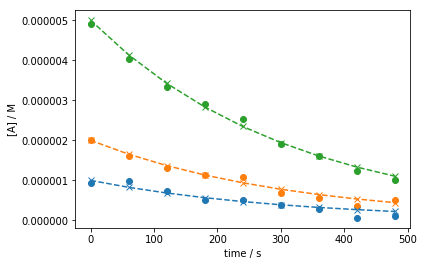

In [13]:
ER_model = KineticModel(observed_kin_data, ER_reactions, true_parameters, educts=['A'])
ER_model.create_native_odesys()
ER_model.show_exp_data()
plt.ylabel('[A] / M')

In [14]:
ER_model.model

In [15]:
ER_likelihood = Likelihood(ER_model, FixStandardDeviation('sigma_kin'))

INFO:pyodesys.native._base:In "/tmp/tmp2VIUv8_pycodeexport_pyodesys_NativeCvodeCode", executing:
"/usr/bin/g++ -c -std=c++11 -Wall -Wextra -fPIC -O2 -ffast-math -funroll-loops -fopenmp -o ./odesys_anyode.o -I/home/niklas/anaconda2/lib/python2.7/site-packages/numpy/core/include -I/home/niklas/anaconda2/lib/python2.7/site-packages/pyodesys/native/sources -I/home/niklas/anaconda2/lib/python2.7/site-packages/pycvodes/include odesys_anyode.cpp"
INFO:pyodesys.native._base:In "/tmp/tmp2VIUv8_pycodeexport_pyodesys_NativeCvodeCode", executing:
"/usr/bin/g++ -pthread -shared -std=c++11 -Wall -Wextra -fPIC -O2 -ffast-math -funroll-loops -fopenmp -o /tmp/tmp2VIUv8_pycodeexport_pyodesys_NativeCvodeCode/_cvode_wrapper.so -I/home/niklas/anaconda2/lib/python2.7/site-packages/numpy/core/include -I/home/niklas/anaconda2/lib/python2.7/site-packages/pyodesys/native/sources -I/home/niklas/anaconda2/lib/python2.7/site-packages/pycvodes/include odesys_anyode.o _cvode_wrapper.o -lsundials_cvodes -lsundials_nv

We'll pickle the likelihood object. This way, we can reuse it in another notebook. We'll take advantage of that in analysis.ipynb

In [16]:
ER_likelihood.pickle_dump_likelihood_specification('ER_likelihood.pkl', 'ER_model.pkl')

### Time-dependent adsorption

Text(0,0.5,'[AS] / M')

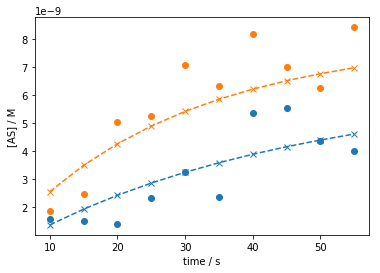

In [17]:
td_adsorption_model = KineticModel(observed_td_adsorption_data, adsorption_equilibrium, true_parameters, educts=['A'], observed_species=['AS'])
td_adsorption_model.create_native_odesys()
td_adsorption_model.show_exp_data()
plt.ylabel('[AS] / M')

In [18]:
td_adsorption_likelihood = Likelihood(td_adsorption_model, FixStandardDeviation('sigma_ads'))

INFO:pyodesys.native._base:In "/tmp/tmpr2EjmV_pycodeexport_pyodesys_NativeCvodeCode", executing:
"/usr/bin/g++ -c -std=c++11 -Wall -Wextra -fPIC -O2 -ffast-math -funroll-loops -fopenmp -o ./odesys_anyode.o -I/home/niklas/anaconda2/lib/python2.7/site-packages/numpy/core/include -I/home/niklas/anaconda2/lib/python2.7/site-packages/pyodesys/native/sources -I/home/niklas/anaconda2/lib/python2.7/site-packages/pycvodes/include odesys_anyode.cpp"
INFO:pyodesys.native._base:In "/tmp/tmpr2EjmV_pycodeexport_pyodesys_NativeCvodeCode", executing:
"/usr/bin/g++ -pthread -shared -std=c++11 -Wall -Wextra -fPIC -O2 -ffast-math -funroll-loops -fopenmp -o /tmp/tmpr2EjmV_pycodeexport_pyodesys_NativeCvodeCode/_cvode_wrapper.so -I/home/niklas/anaconda2/lib/python2.7/site-packages/numpy/core/include -I/home/niklas/anaconda2/lib/python2.7/site-packages/pyodesys/native/sources -I/home/niklas/anaconda2/lib/python2.7/site-packages/pycvodes/include odesys_anyode.o _cvode_wrapper.o -lsundials_cvodes -lsundials_nv

In [19]:
td_adsorption_likelihood.pickle_dump_likelihood_specification('td_adsorption_likelihood.pkl', 'td_adsorption_model.pkl')

### Equilibrium adsorption

In [20]:
def langmuir_isotherm(A, KA, S0):
    KAA = A * KA
    return S0* KAA / (1 + KAA)

In [21]:
conc_A = observed_eq_adsorption_data.index.values

In [22]:
def calc_eq_adsorption(parameters):
    return langmuir_isotherm(conc_A, 10**parameters['KA'], 10**parameters['S0'])

Text(0,0.5,'[A] / M')

Text(0,0.5,'[AS] / M')

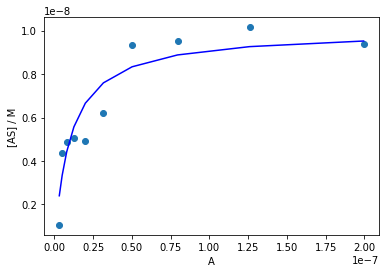

In [23]:
observed_eq_adsorption_data.plot(style='o')
plt.plot(conc_A, calc_eq_adsorption(true_parameters), c='b')
plt.ylabel('[A] / M')
plt.ylabel('[AS] / M')

In [24]:
eq_adsorption_likelihood = Likelihood(calc_eq_adsorption, FixStandardDeviation('sigma_ads'), exp_data_formatted=observed_eq_adsorption_data)

In [25]:
eq_adsorption_likelihood.pickle_dump_likelihood_specification('eq_adsorption_likelihood.pkl', 'eq_adsorption_model.pkl')

# Sampling

We need to define functions that call calc_likelihood from Likelihood Objects.
Without this step, emcee cannot be parallelized because calc_likelihood cannot be pickled. This behavior is a bit odd but no big problem to circumvent.

In [29]:
def logp_ER(parameters):
    return ER_likelihood.calc_likelihood(parameters)

def logp_LH(parameters):
    return LH_likelihood.calc_likelihood(parameters)

def logp_td_adsorption(parameters):
    return td_adsorption_likelihood.calc_likelihood(parameters)

def logp_eq_adsorption(parameters):
    return eq_adsorption_likelihood.calc_likelihood(parameters)

Sampling settings (will be passed to emcee)

In [30]:
# emcee uses walkers to explore the posterior landscape, see their publication
nwalkers = 500
nsteps_test = 1
# what's the upper limit for steps to do?
nsteps = 40000
# only store every n-th step to the file to avoid bloat
thin_by = 50

We can evaluate the three experiments individually or jointly:

the first entry is just the name, the second entry is a dictionary with all logp functions and an associatied name

In [31]:
dict_list = [['ER', {'ER': logp_ER}],
#              ['td', {'td_adsorption': logp_td_adsorption}],
#              ['eq', {'eq_adsorption': logp_eq_adsorption}],
             ['ER_eq', {'ER': logp_ER, 'eq_adsorption': logp_eq_adsorption}],
             ['ER_eq_td', {'ER': logp_ER, 'eq_adsorption': logp_eq_adsorption, 'td_adsorption': logp_td_adsorption}]]

Create a so-called SamplingEnvironment for every case:

This will be handy to create a sampler, pass on the prior_distributions etc.

In [32]:
env_list = []

for x in dict_list:
    curr_name = x[0]
    curr_dict = x[1]
    curr_entry = [x[0]]
    curr_prior = prior_distributions
#     if 'ER' in curr_dict.keys():
#         curr_prior = prior_functions_ER
#     elif 'LH' in curr_dict.keys():
#         curr_prior = prior_functions_LH
        
    curr_env = SamplingEnvironment(curr_prior, curr_dict, reformat_local_parameters)
    
    env_list.append([curr_name, curr_env])

In [33]:
env_list

[['ER',
 ['ER_eq',
 ['ER_eq_td',

# Generate Pool if calculations are supposed to be parralelized

In [34]:
local_pool = Pool(processes=4)

/home/niklas/python_packages/workflows/kinetic_modeling/bayesian_framework.py:136: RuntimeWarning: divide by zero encountered in log
  log_likelihood = np.log(individual_likelihoods).sum()
/home/niklas/python_packages/workflows/kinetic_modeling/bayesian_framework.py:136: RuntimeWarning: divide by zero encountered in log
  log_likelihood = np.log(individual_likelihoods).sum()
/home/niklas/python_packages/workflows/kinetic_modeling/bayesian_framework.py:136: RuntimeWarning: divide by zero encountered in log
  log_likelihood = np.log(individual_likelihoods).sum()
/home/niklas/python_packages/workflows/kinetic_modeling/bayesian_framework.py:136: RuntimeWarning: divide by zero encountered in log
  log_likelihood = np.log(individual_likelihoods).sum()


In [35]:
def choose_pool(name):
    # evaluating langmuire isotherm is very fast, parallelization is slowing it down so don't parralelize
    if name == 'eq.h5':
        return None
    else:
        return local_pool

## Prepare everything

We'll run all samplers for a few steps. Sometimes there are problems which you want to identify quickly. You don't want to finish sampling one chain just for e.g. the second chain to fail. This could go unnoticed if you e.g. started the sampling over night.

In [36]:
def do_sampling(environment, storage_name, sel_nsteps):
    curr_pool = choose_pool(storage_name)
    sampler = environment.setup_sampler(nwalkers, sel_pool=curr_pool, filename=storage_name)
    start_pos = environment.resume_positions_or_create_new_ones(sampler)
    sample_until_convergence(sampler, sel_nsteps, start_pos, thin_by=thin_by)

In [37]:
def make_sure_it_works(environment, storage_name):
    success = False
    while not success:
#         try:
        # We need to generate different starting points
        do_sampling(environment, storage_name, nsteps_test)
        success = True
#         except:
#             success = False

In [38]:
for x in env_list:
    store = x[0] + '.h5'
    make_sure_it_works(x[1], store)

/home/niklas/python_packages/workflows/kinetic_modeling/bayesian_framework.py:136: RuntimeWarning: divide by zero encountered in log
  log_likelihood = np.log(individual_likelihoods).sum()
100%|██████████| 50/50 [00:15<00:00,  2.96it/s]


### Production

Now the sampling for the long chains can be started. This can take a few hours to a few days depending on the posterior landscape and the time needed for the evaluation of every guess of $\theta$

In [39]:
for x in env_list:
    store = x[0] + '.h5'
    print x[1]
    # We need to generate different starting points
    do_sampling(x[1], store, nsteps)

 15%|█▌        | 302450/2000000 [21:26:24<131:26:04,  3.59it/s]


 11%|█         | 212450/2000000 [12:49:50<115:26:56,  4.30it/s]


  1%|          | 19950/2000000 [1:58:14<202:23:10,  2.72it/s]
